In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [14]:
TICKER = "TCS.NS"           
START  = "2015-01-01"
END    = "2025-07-01"

df = yf.download(TICKER, start=START, end=END)
df.head()


C:\Users\popsi\AppData\Local\Temp\ipykernel_160\4196185639.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,
2015-01-01,1087.444702,1096.608001,1085.500947,1096.608001,366830
2015-01-02,1101.926514,1106.839249,1089.602018,1089.772855,925740
2015-01-05,1085.180786,1110.662895,1078.516510,1102.588961,1754242
2015-01-06,1045.173706,1080.417239,1042.354182,1080.417239,2423784
2015-01-07,1032.827881,1059.078956,1028.449138,1055.170169,2636332


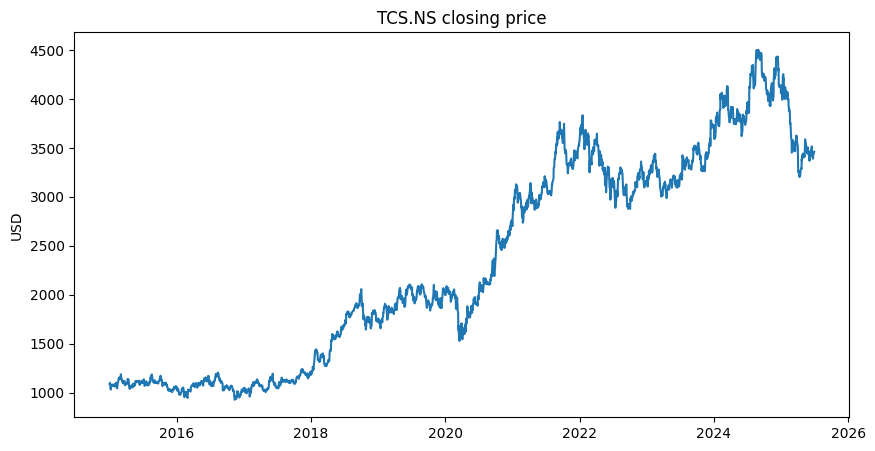

In [28]:
plt.figure(figsize=(10,5))
plt.plot(df["Close"])
plt.title(f"{TICKER} closing price")
plt.ylabel("USD")
plt.show()


In [29]:
ma_200_days= data.Close.rolling(200).mean()

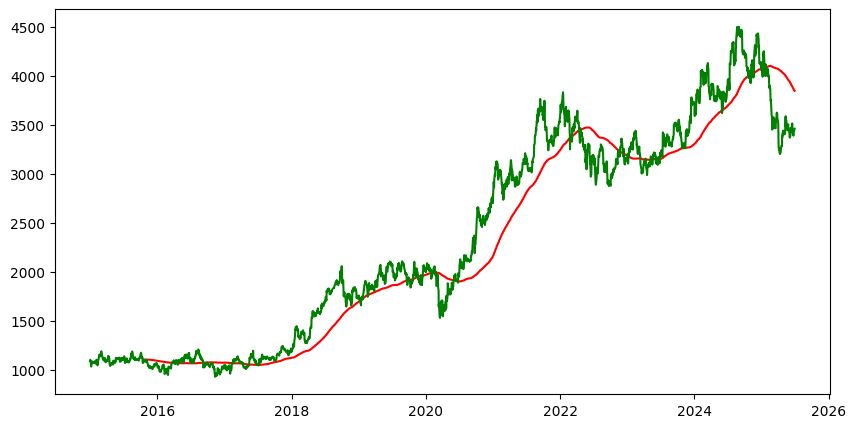

In [30]:
plt.figure(figsize=(10,5))
plt.plot(ma_200_days,"r")
plt.plot(data.Close,"g")
plt.show()


In [16]:
data = df[["Close"]].copy()
data.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data)

WINDOW = 60  # use past 60 days to predict the next day stock price
X, Y = [], []
for i in range(WINDOW, len(scaled)):
    X.append(scaled[i-WINDOW:i, 0])
    Y.append(scaled[i, 0])

X, Y = np.array(X), np.array(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # [samples, timesteps, features]

print("Shape:", X.shape, Y.shape)


Shape: (2530, 60, 1) (2530,)


In [17]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]


In [31]:
tf.keras.backend.clear_session()

model = Sequential([
    LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units = 50, return_sequences=False),
    Dropout(0.2),
    Dense(units = 25, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


C:\Users\popsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
EPOCHS = 20
BATCH  = 32

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=1
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 0.0298 - val_loss: 0.0027
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0014 - val_loss: 0.0072
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 0.0011 - val_loss: 0.0100
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 9.1360e-04 - val_loss: 0.0018
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 8.7596e-04 - val_loss: 0.0053
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 

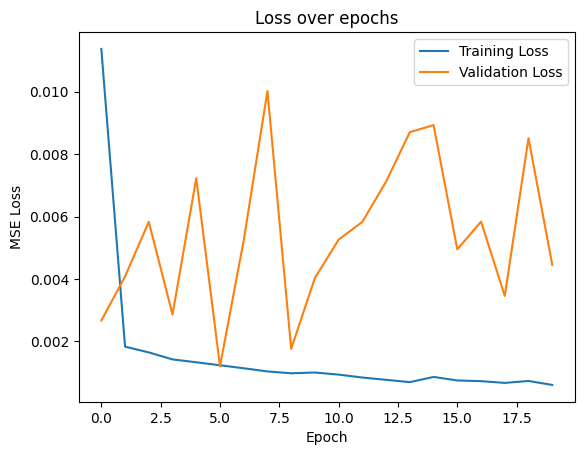

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [23]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(Y_test.reshape(-1,1))


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


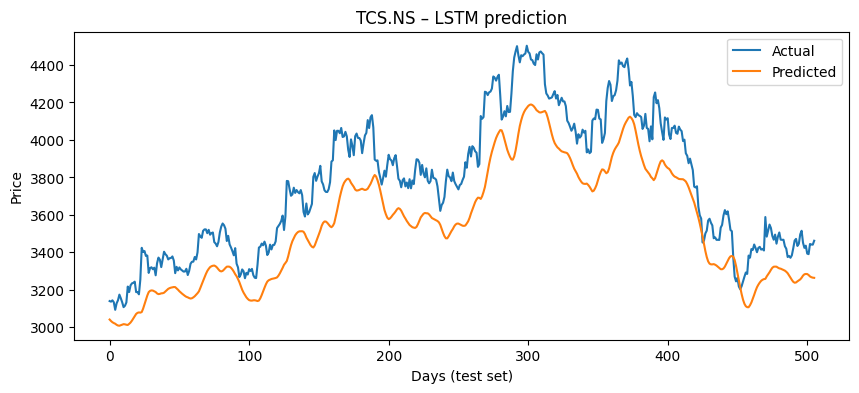

In [24]:
plt.figure(figsize=(10,4))
plt.plot(actual, label="Actual")
plt.plot(pred,   label="Predicted")
plt.title(f"{TICKER} – LSTM prediction")
plt.xlabel("Days (test set)")
plt.ylabel("Price")
plt.legend()
plt.show()


In [25]:
rmse = np.sqrt(mean_squared_error(actual, pred))
mae  = mean_absolute_error(actual, pred)
print(f"RMSE: {rmse:.2f}\nMAE : {mae:.2f}")


RMSE: 238.43
MAE : 218.77


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df_ml = df[["Close"]].copy().dropna()
df_ml["lag1"] = df_ml["Close"].shift(1)
df_ml.dropna(inplace=True)

X_ml = df_ml[["lag1"]]
y_ml = df_ml["Close"]

Xtr, Xte, ytr, yte = train_test_split(X_ml, y_ml, test_size=0.2, shuffle=False)

lr = LinearRegression().fit(Xtr, ytr)
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(Xtr, ytr)

for name, mdl in [("LinearReg", lr), ("RandomForest", rf)]:
    yhat = mdl.predict(Xte)
    print(name,
          "RMSE:", round(np.sqrt(mean_squared_error(yte, yhat)), 2),
          "MAE :", round(mean_absolute_error(yte, yhat), 2))



C:\Users\popsi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


LinearReg RMSE: 48.95 MAE : 34.72
RandomForest RMSE: 253.59 MAE : 166.72


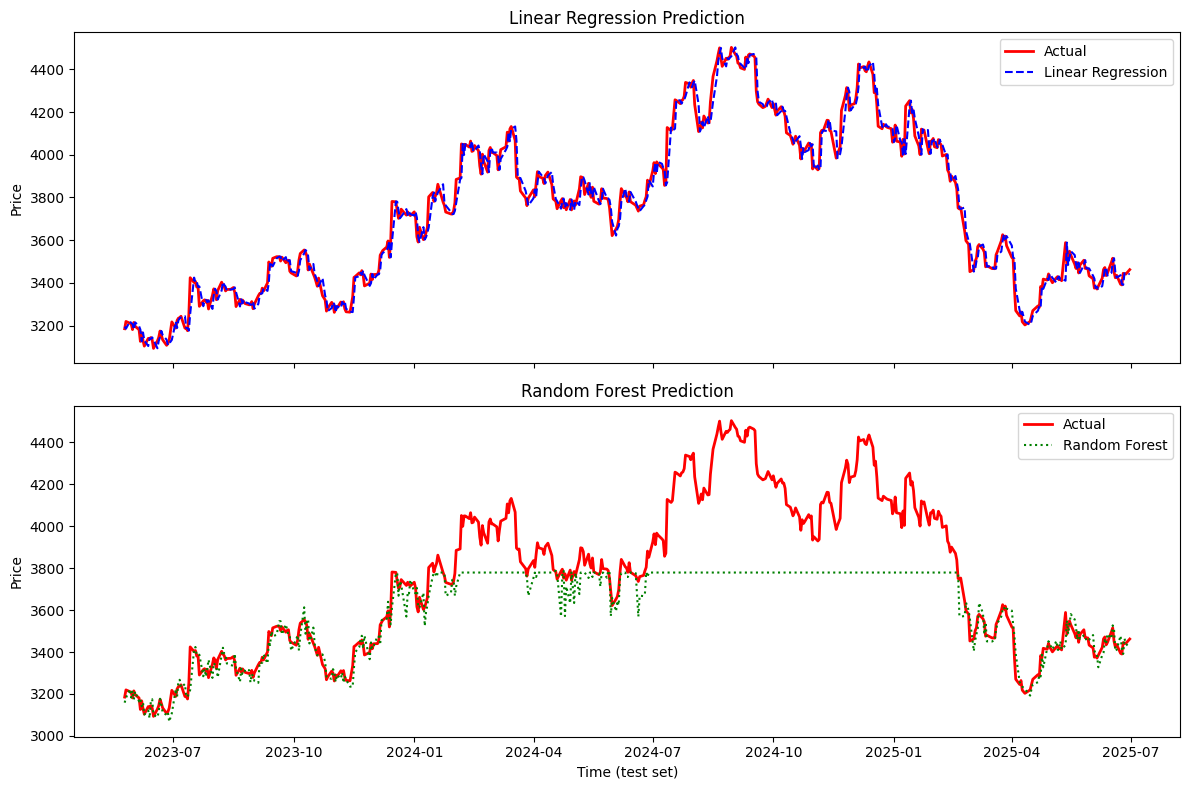

In [34]:
# 6️⃣ Plot actual vs predicted values using subplots
yhat_lr = lr.predict(Xte)
yhat_rf = rf.predict(Xte)
x_axis = yte.index  # Retain date index for proper x-axis

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for Linear Regression
ax[0].plot(x_axis, yte.values, label="Actual", color="red", linewidth=2)
ax[0].plot(x_axis, yhat_lr, label="Linear Regression", linestyle="--", color="blue")
ax[0].set_title("Linear Regression Prediction")
ax[0].set_ylabel("Price")
ax[0].legend()

# Plot for Random Forest
ax[1].plot(x_axis, yte.values, label="Actual", color="red", linewidth=2)
ax[1].plot(x_axis, yhat_rf, label="Random Forest", linestyle=":", color="green")
ax[1].set_title("Random Forest Prediction")
ax[1].set_xlabel("Time (test set)")
ax[1].set_ylabel("Price")
ax[1].legend()

plt.tight_layout()
plt.show()
